In [2]:
import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math

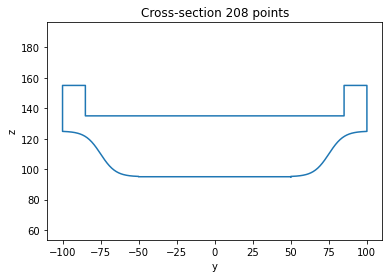

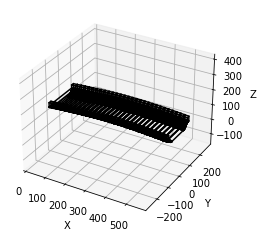

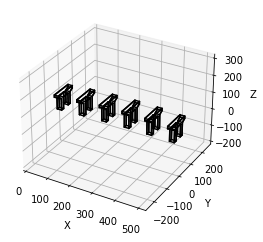

In [12]:
class CrossSection:
    """
    define cross-section for deck structure
    x is the direction perpendicular to the cross-section
    z is the direction pointing upward
    cross sections are defined in yz plane

    """
    def __init__(self): 
        """
        yz: current cross-section's vertices
        C: accumulative cross-section
        
        """
        
        self.yz=None
        self.C=None
        
    def Deck(self,b,c,d,e,f,a=50,h=95):
        """
        @rwh

        """
        x=np.linspace(-5,5,100)
        y=1./(1.+np.exp(-x))
        x=x*b/10+b/2+a
        y=y*c+h
        yz=np.array([
            [a+b,h+c+d+e],
            [a+b-f,h+c+d+e],
            [a+b-f,h+c+d],
            [-(a+b-f),h+c+d],
            [-(a+b-f),h+c+d+e],
            [-a-b,h+c+d+e],
        ])
        s=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
        yz=np.concatenate((s,yz),axis=0)
        s[:,0]=-s[:,0]
        s=s[::-1]
        yz=np.concatenate((yz,s),axis=0)
        yz=np.concatenate((np.array([[50,h]]),yz),axis=0)
        yz=np.concatenate((yz,np.array([[-50,h]])),axis=0)
        self.yz = yz
        self.addsection()
        return yz

    
    def addsection(self):
        """
        input: the coordinate of one cross-section (yz)
        output: the duplication of several cross-sections (C), currently all the same

        """

        # change yz from 2-D matrix to 3-D matrix, then add it to C.
        # x coordinate of C represents faces.
        yz = self.yz.reshape((1,self.yz.shape[0],self.yz.shape[1])) 
        if self.C is None: 
            self.C = yz
        else:
            self.C = np.concatenate((self.C,yz),0) #concatenate: cumulate on x axis
        return self.C 
    
    def Show(self,double):
        """
        show the shape of one cross-section of deck

        """

        # the variable "double" is still incomplete. it is used to construct a cross-section of hollow shape 
        if double == False:
            # connect closed 2d graphics (important)
            idx = np.mod(np.arange(self.yz.shape[0]+1),self.yz.shape[0]) 
            plt.figure() 
            plt.plot(self.yz[idx,0],self.yz[idx,1]) 
            plt.xlabel('y'); plt.ylabel('z')
            plt.axis('equal')
            plt.title("Cross-section {:d} points".format(self.yz.shape[0]))
        else:
            idx=np.mod(np.arange(int(self.yz.shape[0]/2+1)),int(self.yz.shape[0]/2))
            plt.plot(self.yz[idx,0],self.yz[idx,1])
            plt.plot(self.yz[idx+int(self.yz.shape[0]/2),0],self.yz[idx+int(self.yz.shape[0]/2),1]) #矩阵可以直接加常数
            plt.xlabel('y'); plt.ylabel('z')
            plt.axis('equal')
            plt.title("Cross-section {:d} points".format(self.yz.shape[0]))


class CrossSection_column:
    """
    define cross-section for column structure
    x is the direction perpendicular to the cross-section
    z is the direction pointing upward
    cross sections are defined in yz plane

    """
        def __init__(self,trans,t): 
            """
            input: trans: transform of deck structure (deck_member.t)
                   t: number of cross-section for deck (deck_member.n) 
            
            output: C: accumulative cross-section

            goal: 1. column should transform together with deck
                  2. the bottom of column should always be on same plane

            """ 

            # self.z: lift of column due to rotation.  
            self.C=None
            self.z_trans=trans[:,2]
            self.n=t

        def Column(self,a,b,c,d,e,f):
            """
            @rwh

            m: adjustment for column height according to deck's transformation (achieve goal 2).

            """
            for i in range(self.n):
                m=self.z_trans[i]
                yz=np.array([[
                    [a,d],
                    [a,0-m],
                    [a+b,0-m],
                    [a+b,d],
                    [a+b+c,d+e],
                    [a+b+c,d+e+f],
                    [-(a+b+c),d+e+f],
                    [-(a+b+c),d+e],
                    [-(a+b),d],
                    [-(a+b),0-m],
                    [-a,0-m],
                    [-a,d]
                ]])
                
                if self.C is None: 
                    self.C = yz
                else:
                    self.C = np.concatenate((self.C,yz),0) 
            return self.C 
            
        

##########################################################################################################################################
class Member:
    """
    construct the structure of deck

    """
    def __init__(self,C,t1,t2):
        """
        input: C: The accumulative cross-section got from an CrossSection instance
               t1: transformation in y direction
               t2: transformation in z direction
            
        output: v: vertices
                f: faces
        
        args: t: transformation of cross-section
              n: number of cross-section
              nps: number of vertices in one cross-section
        
        *currently, only transformation is applied

        """

        self.n = C.shape[0] 
        self.npts = C.shape[1] 
        
        #################trans

        # t: column is xyz coordinate, row is number of faces 
        t = np.zeros((self.n,3)) 

        # the distance in x direction between faces is 20
        t[:,0] = np.arange(self.n)*20 

        n=self.n
        omega = np.pi / (n-1)
        # y direction
        t[:,1] = np.sin(omega*np.arange(n))*t1  
        # z direction
        t[:,2] = np.sin(omega*np.arange(n))*t2  
        self.t= t

        #################rotate
        # rotvec = np.zeros((n,3))
        # rotvec[:,2]=np.arctan(omega * t1 * np.cos(omega*np.arange(n))) #y direction (z rotate)
        # rotvec[:,1]=-np.arctan(omega * t2 * np.cos(omega*np.arange(n)))
        # self.R = R.from_rotvec(rotvec)   

        self.v = [] #vertices
        self.f = [] #faces

        # xyz: represent xyz coordinate of one cross-section, previous C only has yz coordinate
        xyz = np.zeros((self.npts,3)) 
        for i in range(self.n):
            xyz[:,1:] = C[i,:,:] 
            #c = self.R[i].apply(xyz) + self.t[i,:] 
            c = xyz + self.t[i,:] # +self.t: broadcast
            self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #(c[k,0],c[k,1],c[k,2]) is a list. 
            #if i==0:
                #idx=np.mod(np.arange(self.npts+1),self.npts)
                #self.f=[idx.tolist()]

            # f is four-verticecs connection in adjacent faces
            if i>0:
                m = self.npts * (i-1)
                idx1 = np.arange(m,m+self.npts)   
                idx2 = np.arange(m+self.npts,m+2*self.npts) 
                self.f = self.f + [(idx1[k],idx1[np.mod(k+1,self.npts)],idx2[np.mod(k+1,self.npts)],idx2[k]) for k in range(self.npts)]

    def Show(self):
        v = np.array(self.v)
        plt.figure()
        ax = plt.axes(projection='3d')
        for f in self.f: 
            #print(f)
            idxv = np.array(f)
            ax.plot3D(v[idxv,0], v[idxv,1], v[idxv,2], 'k') #把idxv矩阵对应的四个点找出来

        # find middle face 
        # (min(0) is the minimum of every column, min(1) is the minimum of every row min() is the minimum of all number)   
        vmin = v.min(0); vmax = v.max(0); ctr = (vmin+vmax)/2.  
        half = (vmax-vmin).max()/2.
        ax.set_xlim((ctr[0]-half,ctr[0]+half))
        ax.set_ylim((ctr[1]-half,ctr[1]+half))
        ax.set_zlim((ctr[2]-half,ctr[2]+half)) #合适的显示区域
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

class Member_column:
    """
    construct the structure of column

    goal: pick few cross-section of column to built columns in constant distance
    

    """
        def __init__(self,C,trans,thick): 
            """
            input: C: The accumulative cross-section got from an CrossSection instance
                   trans: transformation of deck
                   thick: thickness of column (length in x direction)
            
            output: v: vertices
                    f: faces
        
            args: dist: number of deck's cross-section between two column
                  n: number of cross-section
                  nps: number of vertices in one cross-section
        
            *currently, only transformation is applied

            """

            # number of cross-section here is equal to the number of cross-section for deck. 
            self.n = C.shape[0] 
            self.npts = C.shape[1]

            #xyz: same as class Member
            xyz = np.zeros((self.npts,3))

            self.v = [] #vertices
            self.f = [] #faces
            dist=5

            # first, pick the location for column
            for i in range(math.floor(self.n/dist)):
                xyz[:,1:] = C[i*dist,:,:] 
                #c = self.R[i].apply(xyz) + self.t[i,:]
                c = xyz + trans[i*dist,:]
                self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #(c[k,0],c[k,1],c[k,2]) is a list
            
            # next, generate the thickness of column (number of faces is doubled)
            # totally [(math.floor(self.n/dist))*2] faces
            xyz = np.zeros((self.npts,3))
            for i in range(math.floor(self.n/dist)):  
                xyz[:,1:] = C[i*dist,:,:]
                c = xyz + trans[i*dist,:]+np.array([thick,0,0])
                self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #need further revise
                
                # construct faces in x direction
                m = self.npts*(i)
                idx1 = np.arange(m,m+self.npts)    #first face
                idx2 = np.arange(m+self.npts*math.floor(self.n/dist),m+2*self.npts*math.floor(self.n/dist))  #second face
                self.f = self.f + [(idx1[k],idx1[np.mod(k+1,self.npts)],idx2[np.mod(k+1,self.npts)],idx2[k]) for k in range(self.npts)]
            
            # construct faces in yz plane
            for i in range((math.floor(self.n/dist))*2): 
                idx=np.mod(np.arange(self.npts+1),self.npts)+self.npts*i
                self.f=self.f+[tuple(idx)]

        def Show(self):
            v = np.array(self.v)
            plt.figure()
            ax = plt.axes(projection='3d')
            for ff in self.f: 
            #print(f)
                idxv = np.array(ff)
                ax.plot3D(v[idxv,0], v[idxv,1], v[idxv,2], 'k') 
            
            vmin = v.min(0); vmax = v.max(0); ctr = (vmin+vmax)/2.  
            half = (vmax-vmin).max()/2.
            ax.set_xlim((ctr[0]-half,ctr[0]+half))
            ax.set_ylim((ctr[1]-half,ctr[1]+half))
            ax.set_zlim((ctr[2]-half,ctr[2]+half)) 
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            
        
###############################################################################################################################################

if __name__ == "__main__":
    t=30
    cs = CrossSection()
    for i in range(t):
    # create constant rectangular cross section
        cs.Deck(50,30,10,20,15)
    cs.Show(False)
    m=Member(cs.C,10,10)
    m.Show()
    #print(m.t)
    col=CrossSection_column(m.t,t)
    col.Column(17,15,18,70,12,13)
    n=Member_column(col.C,m.t,20)
    n.Show()

